# CLIP + Stable unCLIP Reconstruction Demo

This notebook mirrors the new CLIP-based restoration flow in `src/knn_restore.py`.
It loads Imagenette samples, trains the residual MLP to map corrupted CLIP image
embeddings back to the clean space, and decodes the reconstructions with
`sd2-community/stable-diffusion-2-1-unclip-small`. The last section visualizes
clean/corrupted/reconstructed triplets side by side.

In [1]:
from pathlib import Path
import sys

import torch
from torchvision import transforms
import matplotlib.pyplot as plt


def find_src_root():
    cwd = Path.cwd()
    candidates = [cwd, cwd / "RAE"]
    for parent in cwd.parents:
        candidates.extend([parent, parent / "RAE"])
    for base in candidates:
        src = base / "src"
        if src.exists():
            return base, src
    raise RuntimeError(
        "Could not locate 'src' directory. Run this notebook from the repo root or RAE/."
    )


repo_root, src_root = find_src_root()
if str(src_root) not in sys.path:
    sys.path.append(str(src_root))

from knn_restore import (
    EncoderConfigs,
    ReconstructConfigs,
    GlobalConfigs,
    load_encoder,
    extract_features,
    create_dataloaders,
    train,
    evaluate,
    seed_everything,
    set_up,
)
from restore_methods import evaluate_reconstruction
import dataloader
from diffusers import StableUnCLIPImg2ImgPipeline


/orcd/scratch/orcd/010/jianggy/micromamba/envs/rae/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/orcd/scratch/orcd/010/jianggy/micromamba/envs/rae/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assign

In [2]:
global_cfg, encoder_cfg, restore_cfg, unclip_cfg = set_up()
device = torch.device(global_cfg.device)
seed = global_cfg.seed
seed_everything(seed)

# Notebook-friendly overrides
batch_size = 32
num_workers = 4
corrupt_range = (0.50, 0.70)
max_train = 512
max_val = 128
num_visualize = 4

restore_cfg.hidden_dims = 1024
restore_cfg.epochs = 3

global_cfg.batch_size = batch_size
global_cfg.num_workers = num_workers
global_cfg.corrupt_range = corrupt_range
global_cfg.scheme = "occlude"

generator = torch.Generator(device=device).manual_seed(seed)
global_cfg.generator = generator

torch.manual_seed(seed)

IMAGENET_MEAN = torch.tensor((0.485, 0.456, 0.406)).view(1, 3, 1, 1)
IMAGENET_STD = torch.tensor((0.229, 0.224, 0.225)).view(1, 3, 1, 1)


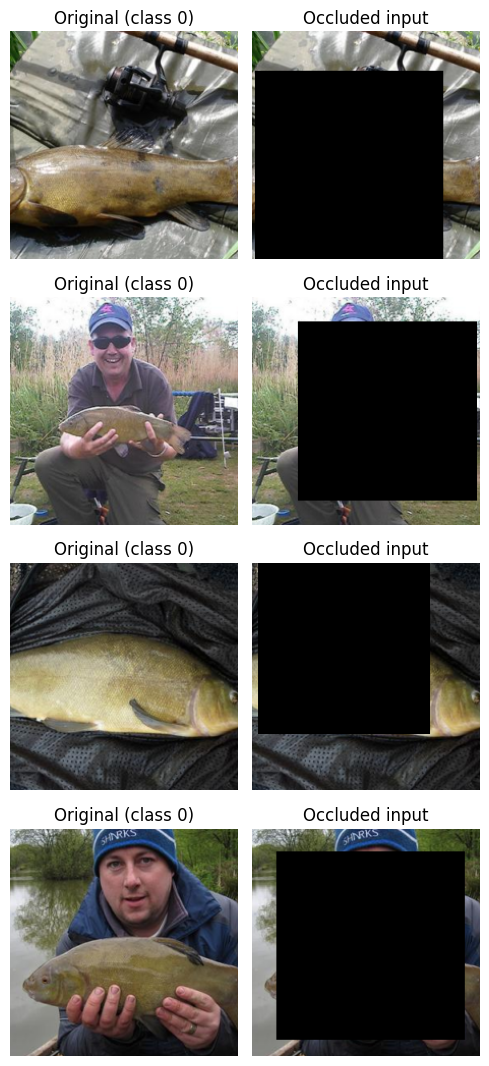

In [3]:
clean_train_loader, clean_val_loader = dataloader.get_imagenette_loaders(
    scheme="baseline",
    corrupt_range=None,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
corrupt_train_loader, corrupt_val_loader = dataloader.get_imagenette_loaders(
    scheme=global_cfg.scheme,
    corrupt_range=global_cfg.corrupt_range,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

def denormalize(batch: torch.Tensor) -> torch.Tensor:
    return (batch * IMAGENET_STD.to(batch) + IMAGENET_MEAN.to(batch)).clamp(0, 1)

clean_samples, corrupt_samples, sample_labels = [], [], []
clean_iter = iter(clean_val_loader)
corrupt_iter = iter(corrupt_val_loader)
while len(clean_samples) < num_visualize:
    clean_batch, clean_lbl = next(clean_iter)
    corrupt_batch, _ = next(corrupt_iter)
    for idx in range(clean_batch.size(0)):
        clean_samples.append(denormalize(clean_batch[idx:idx+1])[0].cpu())
        corrupt_samples.append(denormalize(corrupt_batch[idx:idx+1])[0].cpu())
        sample_labels.append(int(clean_lbl[idx]))
        if len(clean_samples) >= num_visualize:
            break

fig, axes = plt.subplots(num_visualize, 2, figsize=(5, 2.7 * num_visualize))
for row in range(num_visualize):
    axes[row, 0].imshow(clean_samples[row].permute(1, 2, 0).numpy())
    axes[row, 0].set_title(f"Original (class {sample_labels[row]})")
    axes[row, 0].axis("off")
    axes[row, 1].imshow(corrupt_samples[row].permute(1, 2, 0).numpy())
    axes[row, 1].set_title("Occluded input")
    axes[row, 1].axis("off")
plt.tight_layout()

In [4]:
encoder_bundle = load_encoder(encoder_cfg, device)

clean_train_embeddings, train_labels = extract_features(
    encoder_bundle,
    clean_train_loader,
    scheme="baseline",
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed),
    noise_std=None,
    max_items=max_train,
)
corrupt_train_embeddings, _ = extract_features(
    encoder_bundle,
    corrupt_train_loader,
    scheme=global_cfg.scheme,
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 1),
    noise_std=None,
    max_items=max_train,
)
clean_valid_embeddings, valid_labels = extract_features(
    encoder_bundle,
    clean_val_loader,
    scheme="baseline",
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 2),
    noise_std=None,
    max_items=max_val,
)
corrupt_valid_embeddings, _ = extract_features(
    encoder_bundle,
    corrupt_val_loader,
    scheme=global_cfg.scheme,
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 3),
    noise_std=None,
    max_items=max_val,
)

train_loader, train_eval_loader, val_loader = create_dataloaders(
    global_cfg,
    restore_cfg,
    clean_train_embeddings,
    corrupt_train_embeddings,
    clean_valid_embeddings,
    corrupt_valid_embeddings,
)

model, losses = train(
    restore_cfg,
    train_loader,
    val_loader,
    device=device,
    feature_dim=encoder_bundle["feature_dim"],
    normalize_outputs=encoder_bundle.get("normalize", True),
)


# model = torch.nn.Identity().to(device) # Uncomment to skip reconstruction and just evaluate the corrupted inputs
train_pred, valid_pred = evaluate(
    model,
    train_eval_loader,
    val_loader,
    device,
    encoder_bundle.get("normalize", True),
)
print("Train metrics:", evaluate_reconstruction(train_pred, clean_train_embeddings))
print("Valid metrics:", evaluate_reconstruction(valid_pred, clean_valid_embeddings))

Training epochs: 100%|██████████| 3/3 [00:00<00:00, 24.03it/s]

Epoch 1/3 - train_loss: 0.237825 - val_loss: 0.128620
Epoch 2/3 - train_loss: 0.155988 - val_loss: 0.117321
Epoch 3/3 - train_loss: 0.142845 - val_loss: 0.112695
Train metrics: {'mse': 0.11141019314527512, 'mean_l2': 9.146308898925781, 'mean_cos': 0.8604947328567505}
Valid metrics: {'mse': 0.112694650888443, 'mean_l2': 9.175143241882324, 'mean_cos': 0.8572612404823303}


In [5]:

pipe_dtype = torch.float16 if device.type == "cuda" else torch.float32
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip-small",
    torch_dtype=pipe_dtype,
)
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)
pipe.enable_attention_slicing()

num_recon = min(num_visualize, valid_pred.size(0))
clip_embeds = valid_pred[:num_recon].to(device=device, dtype=pipe_dtype)
prompts = [""] * num_recon
generator = torch.Generator(device=device).manual_seed(seed)
with torch.inference_mode():
    recon = pipe(
        image=None,
        prompt=prompts,
        image_embeds=clip_embeds,
        guidance_scale=5.0,
        num_inference_steps=25,
        generator=generator,
    ).images

recon_tensors = [transforms.ToTensor()(img) for img in recon]


Loading pipeline components...: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


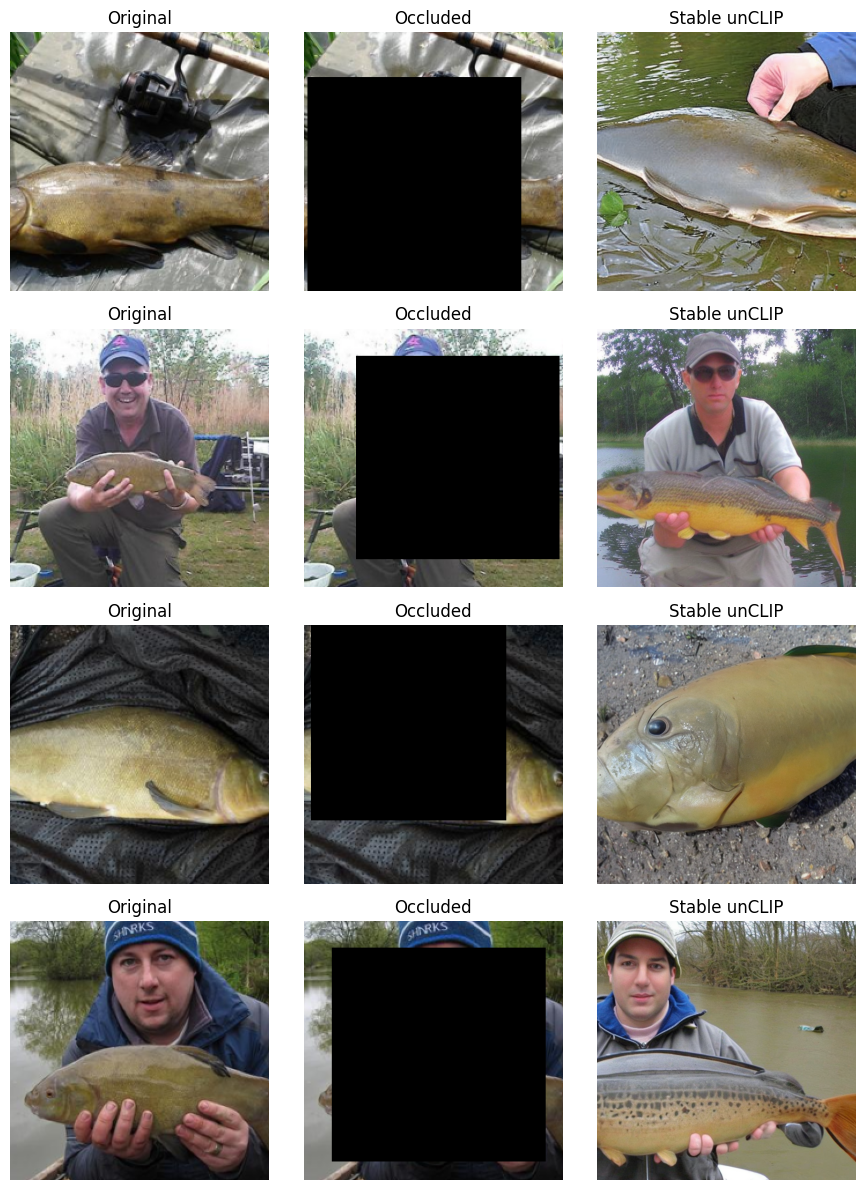

In [6]:
fig, axes = plt.subplots(num_recon, 3, figsize=(9, 3 * num_recon))
columns = ["Original", "Occluded", "Stable unCLIP"]
for row in range(num_recon):
    triplet = [clean_samples[row], corrupt_samples[row], recon_tensors[row]]
    for col in range(3):
        axes[row, col].imshow(triplet[col].permute(1, 2, 0).numpy())
        axes[row, col].set_title(columns[col])
        axes[row, col].axis("off")
plt.tight_layout()